Kaggle competition: Predict Future Sales

In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

Submissions are evaluated by root mean squared error (RMSE). True target values are clipped into [0,20] range.
For each id in the test set, you must predict a total number of sales.


In [187]:
# Importo las librerias que voy a utilizar.

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [188]:
# Leo los diferentes datasets de la competición.

dataset_filenames = ['item_categories', 'items', 'sales_train', 'sample_submission', 'shops', 'test']
datasets_path = 'C:/Users/arnau/OneDrive/Documentos/Python Scripts/Kaggle/Predict Future Sales/'
for dataset_filename in dataset_filenames:
    exec(dataset_filename + "= pd.read_csv(datasets_path+dataset_filename+'.csv')")
    

In [189]:
# Imprimo el dataset 'sales_train'
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0
6,02.01.2013,0,25,2565,549.00,1.0
7,04.01.2013,0,25,2572,239.00,1.0
8,11.01.2013,0,25,2572,299.00,1.0
9,03.01.2013,0,25,2573,299.00,3.0


Voy a empezar con la limpieza y tratamiento del dataset.

En primer lugar voy a eliminar la columna 'date'. El dia en que se produce la venta no me resulta interesante dado que la competición me pide ventas mensuales y el dataframe ya contiene también una columna que indica los distintos mes-año.

También voy a eliminar la columna de los precios. Aunque si que puede ser interesante realizar un estudio con los precios de cada producto no creo que resulte muy relevante a la hora de predecir ventas totales y añadiría bastante complejidad al proyecto.

In [190]:
# Creo un diccionario que relaciona cada número de la columna 'date_block_num' con la string 'MM.YYYY' 
# Correspondiente.
date_dict = {}
for date_block_num in sales_train.date_block_num.unique():
    temp_df = sales_train.loc[sales_train.date_block_num==date_block_num]
    date_dict[date_block_num] = temp_df.iloc[0].date[3:]
    

In [191]:
# Elimino las columnas que no voy a utilizar.
cleaned_train = sales_train.drop(columns=['date', 'item_price'])

In [192]:
cleaned_train

,date_block_num,shop_id,item_id,item_cnt_day
0,0,59,22154,1.0
1,0,25,2552,1.0
2,0,25,2552,-1.0
3,0,25,2554,1.0
4,0,25,2555,1.0
5,0,25,2564,1.0
6,0,25,2565,1.0
7,0,25,2572,1.0
8,0,25,2572,1.0
9,0,25,2573,3.0


In [193]:
# Confirmo que no hay nulos.
cleaned_train.isnull().sum()

date_block_num    0
shop_id           0
item_id           0
item_cnt_day      0
dtype: int64

Ahora voy a dibujar un gráfico de lineas para analizar la tendencia de las ventas.

In [194]:
# Creo un dataframe con las ventas de cada mes.
monthly_sales = cleaned_train[['date_block_num', 'item_cnt_day']]
monthly_sales = monthly_sales.groupby('date_block_num').sum()

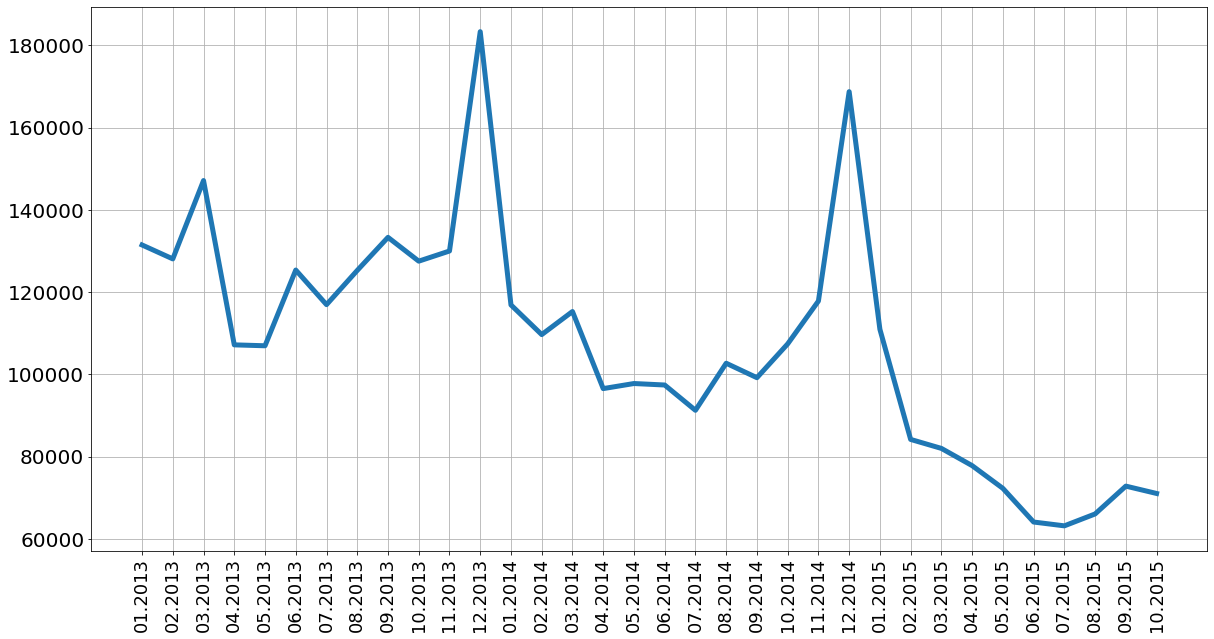

In [195]:
# Imprimo el gráfico de líneas.
plt.figure(figsize=(20,10))
plt.plot(monthly_sales, linewidth=5)
plt.yticks(fontsize=20)
plt.xticks(list(date_dict.keys()), list(date_dict.values()), fontsize=18, rotation=90)
plt.grid()

Se puede detectar una clara tendencia bajista de las ventas. Además, si nos fijamos en las ventas de diciembre se puede observar que hay un gran incremento de las ventas.

Dado que el precio tiene una clara tendencia un algoritmo de regresión lineal debería producir unas predicciones bastante acertadas. Para conseguir un mayor acierto en la predicción posteriormente añadire un componente mensual que indicara la desviación de esta regresion segun el mes.

In [196]:
x = list(monthly_sales.index)
y = list(monthly_sales.item_cnt_day)

learning_rate = 0.02
epochs = 1000

X = tf.placeholder(float)
Y = tf.placeholder(float)

W = tf.Variable(np.random.randn(), name = "W") 
b = tf.Variable(np.random.randn(), name = "b") 

Y_pred = tf.add(tf.multiply(X, W), b)

error = tf.reduce_sum(tf.pow(Y_pred-Y, 2)) / (2 * len(monthly_sales)) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(error) 
init = tf.global_variables_initializer() 

In [197]:
training_error = []
with tf.Session() as sess: 
    sess.run(init) 
    
    for epoch in range(epochs): 
        for (_x, _y) in zip(x, y): 
            sess.run(optimizer, feed_dict = {X : _x, Y : _y}) 
        if (epoch + 1) % 50 == 0: 
            c = sess.run(error, feed_dict = {X : x, Y : y}) 
            print("Epoch", (epoch + 1), ": e =", c, "W =", sess.run(W), "b =", sess.run(b)) 
        training_error.append(sess.run(error, feed_dict ={X: x, Y: y}))
        
    weight = sess.run(W) 
    bias = sess.run(b) 

Epoch 50 : e = 2369036000.0 W = 1320.9358 b = 28146.23
Epoch 100 : e = 1608265500.0 W = 630.71326 b = 50456.94
Epoch 150 : e = 1119866000.0 W = 80.19316 b = 68251.914
Epoch 200 : e = 805635100.0 W = -358.89935 b = 82445.11
Epoch 250 : e = 602918000.0 W = -709.1169 b = 93765.52
Epoch 300 : e = 471710720.0 W = -988.4502 b = 102794.68
Epoch 350 : e = 386450660.0 W = -1211.2451 b = 109996.28
Epoch 400 : e = 330783940.0 W = -1388.9403 b = 115740.09
Epoch 450 : e = 294229950.0 W = -1530.6741 b = 120321.484
Epoch 500 : e = 270066880.0 W = -1643.7194 b = 123975.555
Epoch 550 : e = 253970740.0 W = -1733.8811 b = 126889.93
Epoch 600 : e = 243152420.0 W = -1805.7943 b = 129214.45
Epoch 650 : e = 235809070.0 W = -1863.1512 b = 131068.45
Epoch 700 : e = 230768820.0 W = -1908.9056 b = 132547.42
Epoch 750 : e = 227270290.0 W = -1945.3857 b = 133726.6
Epoch 800 : e = 224810100.0 W = -1974.4873 b = 134667.27
Epoch 850 : e = 223057820.0 W = -1997.7051 b = 135417.77
Epoch 900 : e = 221794620.0 W = -2016.

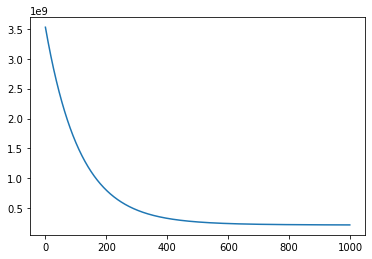

In [198]:
plt.plot(training_error)

Ya tenemos nuestro modelo de regressión lineal entrenado de forma que reduce al máximo el RMSE.
Ahora voy a dibujar la recta de regression sobre las ventas y a estudiar la variación que se produce en función del mes.

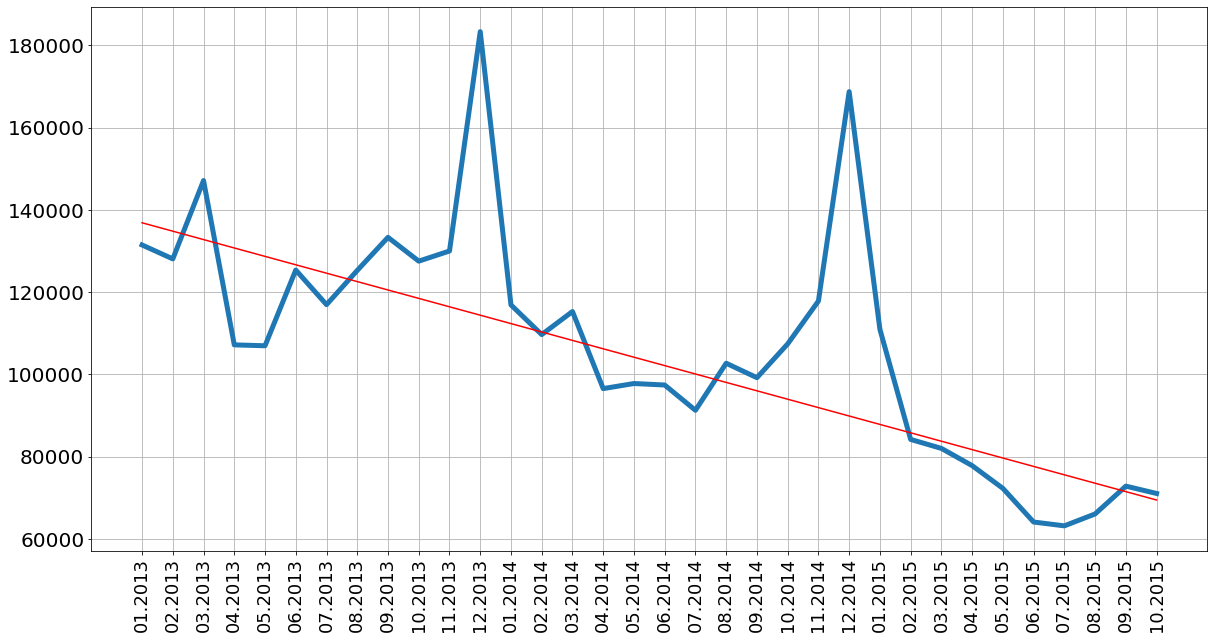

In [199]:
# Dibujo la recta de regressión sobre la gráfica de ventas
regression_line = [weight * x + bias for x in list(monthly_sales.index)]

plt.figure(figsize=(20,10))
plt.plot(monthly_sales, linewidth=5)
plt.plot(regression_line, color='red')
plt.yticks(fontsize=20)
plt.xticks(list(date_dict.keys()), list(date_dict.values()), fontsize=18, rotation=90)
plt.grid()

In [200]:
# Calculo la variación de las ventas sobre la regressión lineal según el mes.

sales_increment_month = monthly_sales[monthly_sales.columns]
sales_increment_month['regression'] = regression_line
sales_increment_month['increment'] = sales_increment_month.item_cnt_day - sales_increment_month.regression
sales_increment_month.drop(columns=(['regression', 'item_cnt_day']), inplace=True)
sales_increment_month.reset_index(inplace=True)

In [201]:
sales_increment_month['month'] = sales_increment_month.date_block_num.map(lambda x: date_dict[x][:2])
sales_increment_month.drop(columns=['date_block_num'], inplace=True)

In [202]:
sales_increment_month = sales_increment_month.groupby('month').mean()

In [203]:
sales_increment_month

,increment
month,
01,7421.783203
02,-2993.445801
03,6541.991862
04,-12375.237142
05,-11838.466146
06,-6506.028483
07,-9626.924154
08,-31.486491
09,5775.284505


Ahora voy a hacer una predicción de las ventas totales según la recta de regresión y la variación mensual.

In [204]:
monthly_sales_given = list(monthly_sales.item_cnt_day)
prediction = [np.nan for element in monthly_sales_given]
for i in range(12):
    monthly_sales_given.append(np.nan)
total_sales_next_year_prediction = pd.DataFrame({'date_block_num': np.arange(46),
                                                'total_sales': monthly_sales_given})

In [205]:
regression_line = [weight * x + bias for x in list(total_sales_next_year_prediction.index)]
prediction.append(regression_line[34]+sales_increment_month.increment.iloc[10])
prediction.append(regression_line[35]+sales_increment_month.increment.iloc[11])
prediction.append(regression_line[36]+sales_increment_month.increment.iloc[0])
prediction.append(regression_line[37]+sales_increment_month.increment.iloc[1])
prediction.append(regression_line[38]+sales_increment_month.increment.iloc[2])
prediction.append(regression_line[39]+sales_increment_month.increment.iloc[3])
prediction.append(regression_line[40]+sales_increment_month.increment.iloc[4])
prediction.append(regression_line[41]+sales_increment_month.increment.iloc[5])
prediction.append(regression_line[42]+sales_increment_month.increment.iloc[6])
prediction.append(regression_line[43]+sales_increment_month.increment.iloc[7])
prediction.append(regression_line[44]+sales_increment_month.increment.iloc[8])
prediction.append(regression_line[45]+sales_increment_month.increment.iloc[9])

In [206]:
date_dict[34] = '11.2015'
date_dict[35] = '12.2015'
date_dict[36] = '01.2016'
date_dict[37] = '02.2016'
date_dict[38] = '03.2016'
date_dict[39] = '04.2016'
date_dict[40] = '05.2016'
date_dict[41] = '06.2016'
date_dict[42] = '07.2016'
date_dict[43] = '08.2016'
date_dict[44] = '09.2016'
date_dict[45] = '10.2016'

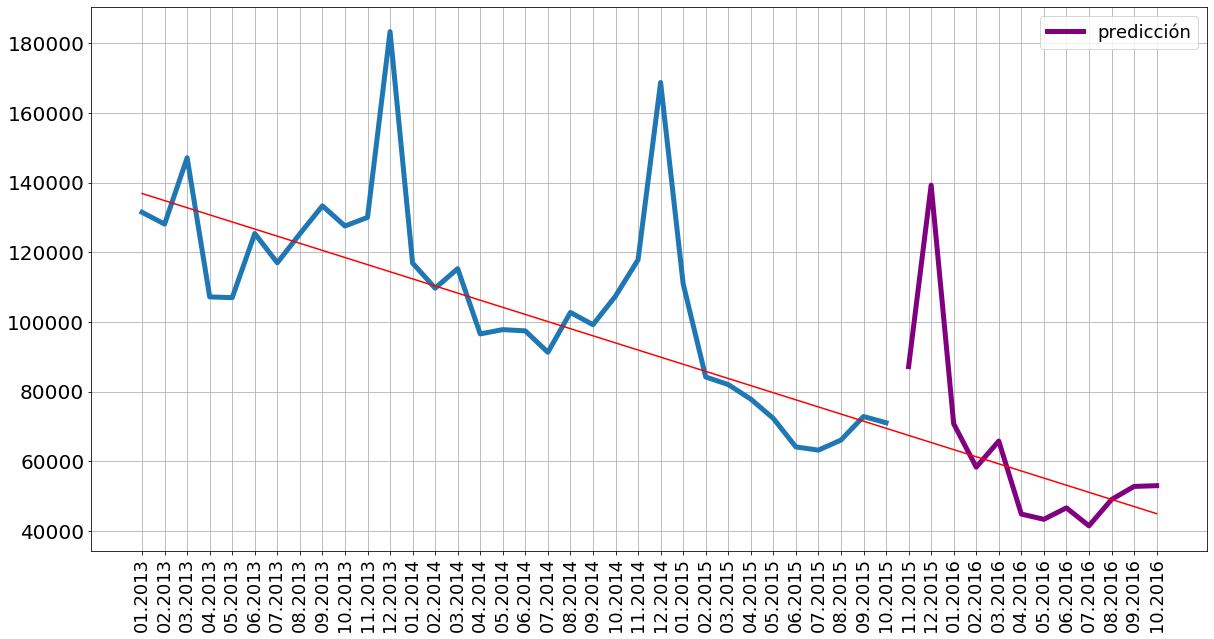

In [207]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(46), monthly_sales_given, linewidth=5)
plt.plot(np.arange(46), prediction, linewidth=5, color='purple', label='predicción')
plt.plot(regression_line, color='red')
plt.legend(fontsize=18)
plt.yticks(fontsize=20)
plt.xticks(list(date_dict.keys()), list(date_dict.values()), fontsize=18, rotation=90)
plt.grid()

Esta sería mi predicción de las ventas totales de la empresa para el próximo año. Pero lo que piden para el concurso de Kaggle es la predicción de las ventas de cada producto (en cada tienda) para el siguiente mes (noviembre). Voy a usar la misma predicción que las ventas totales pero ajustandola a cada par tienda-producto con una regla de tres según ventas mensuales, ya que entrenar una regresión lineal para cada producto no sería eficiente ni efectivo.

En primer lugar voy a estudiar el cierre de las tiendas, para comprobar que la desminucion de las ventas no esta relacionada con la cantidas de tiendas abiertas.

In [208]:
# Creo un dataset con las tiendas que tienen algun mes sin ventas.
shop_sells = cleaned_train.drop(columns=['item_id', 'item_cnt_day'], inplace=True)
shop_sells = cleaned_train.groupby(['shop_id', 'date_block_num']).sum()
shop_sells.reset_index(inplace=True)
shop_sells = shop_sells.groupby('date_block_num').count()
shop_sells.reset_index(inplace=True)

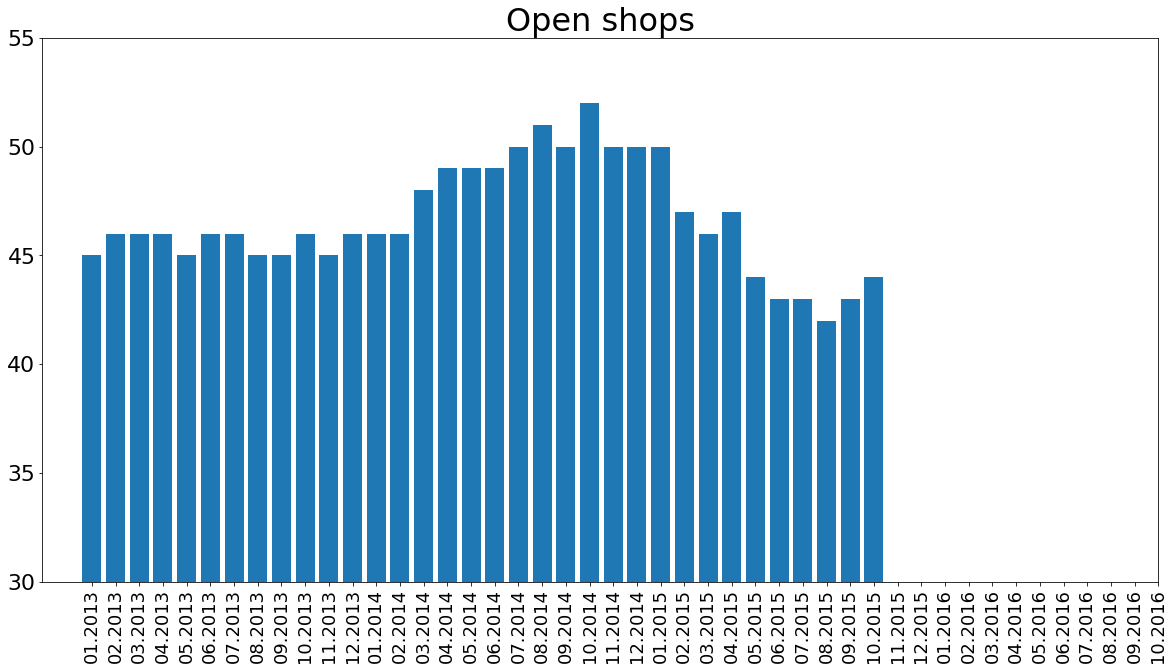

In [209]:
# Dibujo un gráfico con la cantidad de tiendas abiertas según el mes.
plt.figure(figsize=(20,10))
plt.bar(shop_sells.date_block_num, shop_sells.shop_id)
plt.title('Open shops', fontsize=32)
plt.yticks(fontsize=22)
plt.ylim(30, 55)
plt.xticks(list(date_dict.keys()), list(date_dict.values()), fontsize=18, rotation=90)
plt.show()
    

La cantidad de tiendas abiertas no disminuye con el paso de los meses como sí lo hacen las ventas. No parece que la disminución de las ventas dependa de la cantidad de tiendas abiertas.

Mi siguiente objetivo es ajustar la regression lineal general a cada uno de los productos-tienda. Para ello voy a usar una regla de tres con las ventas mensuales de cada uno de los productos-tienda y las ventas generales.

In [274]:
# Voy a sacar un diccionario con la cantidad de meses que cada tienda esta abierta.
cleaned_train.sort_values(by=['shop_id'], inplace=True)
months_opened = {}
for i in cleaned_train.shop_id.unique():
    months_opened[i] = len(cleaned_train.loc[cleaned_train.shop_id==i].date_block_num.unique())

In [277]:
# Voy a sacar un diccionario con la cantidad de ventas mensuales medias de cada ID.
sales_train_ID = sales_train.set_index(['shop_id', 'item_id']).join(test.set_index(['shop_id', 'item_id']))
sales_train_ID.reset_index(inplace=True)
sales_train_ID.sort_values(by='ID', inplace=True)
ID_monthly_sales = {}
for i in sales_train_ID.ID.unique():
    if i % 500 == 0:
        print('{}/214199'.format(i))
    total_sales = sales_train_ID.loc[sales_train_ID.ID==i].item_cnt_day.count()
    total_months_opened = months_opened[sales_train_ID.loc[sales_train_ID.ID==i].shop_id.iloc[0]]
    ID_monthly_sales[i] = total_sales/total_months_opened

0.0/214199
1000.0/214199
1500.0/214199
2000.0/214199
3000.0/214199
3500.0/214199
6000.0/214199
8000.0/214199
10500.0/214199
11000.0/214199
11500.0/214199
12000.0/214199
12500.0/214199
13000.0/214199
16500.0/214199
17000.0/214199
17500.0/214199
18500.0/214199
20500.0/214199
21000.0/214199
21500.0/214199
22000.0/214199
23500.0/214199
24000.0/214199
25500.0/214199
26500.0/214199
27000.0/214199
27500.0/214199
28500.0/214199
29000.0/214199
31500.0/214199
32500.0/214199
33500.0/214199
37000.0/214199
37500.0/214199
38500.0/214199
41500.0/214199
42000.0/214199
42500.0/214199
43000.0/214199
44000.0/214199
44500.0/214199
46000.0/214199
46500.0/214199
47000.0/214199
47500.0/214199
48000.0/214199
48500.0/214199
49000.0/214199
49500.0/214199
51000.0/214199
52000.0/214199
52500.0/214199
53000.0/214199
53500.0/214199
54500.0/214199
56500.0/214199
57000.0/214199
57500.0/214199
58000.0/214199
58500.0/214199
59000.0/214199
60000.0/214199
61500.0/214199
62500.0/214199
63000.0/214199
67000.0/214199
67500.

C:\Users\arnau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


IndexError: single positional indexer is out-of-bounds

In [302]:
valid_ID = list(ID_monthly_sales.keys())
nov_pred = prediction[34]
total_monthly_sales_mean = np.mean(monthly_sales_given[:34])

In [296]:
my_pred = sample_submission

In [298]:
my_pred['prediction'] = 0.

In [304]:
for i in my_pred.index:
    if i%1000 == 0:
        print('{}/214199'.format(i))
    if my_pred.iloc[i].ID in valid_ID:
        my_pred.prediction.iloc[i] = (nov_pred*ID_monthly_sales[my_pred.ID.iloc[i]])/total_monthly_sales_mean

0/214199
1000/214199
2000/214199
3000/214199
4000/214199
5000/214199
6000/214199
7000/214199
8000/214199
9000/214199
10000/214199
11000/214199
12000/214199
13000/214199
14000/214199
15000/214199
16000/214199
17000/214199
18000/214199
19000/214199
20000/214199
21000/214199
22000/214199
23000/214199
24000/214199
25000/214199
26000/214199
27000/214199
28000/214199
29000/214199
30000/214199
31000/214199
32000/214199
33000/214199
34000/214199
35000/214199
36000/214199
37000/214199
38000/214199
39000/214199
40000/214199
41000/214199
42000/214199
43000/214199
44000/214199
45000/214199
46000/214199
47000/214199
48000/214199
49000/214199
50000/214199
51000/214199
52000/214199
53000/214199
54000/214199
55000/214199
56000/214199
57000/214199
58000/214199
59000/214199
60000/214199
61000/214199
62000/214199
63000/214199
64000/214199
65000/214199
66000/214199
67000/214199
68000/214199
69000/214199
70000/214199
71000/214199
72000/214199
73000/214199
74000/214199
75000/214199
76000/214199
77000/214199

In [307]:
my_pred.drop(columns=['item_cnt_month'], inplace=True)
my_pred.set_index('ID', inplace=True)

In [310]:
my_pred.set_index('ID', inplace=True)

In [313]:
my_pred.rename(columns={'prediction': 'item_cnt_month'}, inplace=True)

In [314]:
my_pred.to_csv('C:/Users/arnau/OneDrive/Documentos/Python Scripts/Kaggle/Predict Future Sales/Predictions.csv')

Mi resultado ha sido un RMSE de 1.14791.   Puesto 5371/9020. 

El ganador del concurso ha obtenido un RMSE de 0.76955